In [1]:
# Sets seeds for reproducability.

import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [2]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import *
from accuracy import *
from transformers import get_linear_schedule_with_warmup
from model import Model
from torch import nn

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions_train=8, num_actions_valid=6, batch_size=4, epochs=25, lr=0.001, MAX_DETECTIONS=20):
    num_actions = num_actions_train
    
    train_dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    valid_dataset = YouCookII(num_actions_valid, "/h/sagar/ece496-capstone/datasets/ycii")
    
    train_size = len(train_dataset)
    valid_size = len(valid_dataset)
    
    print("Training Dataset Size: {}, Validation Dataset Size: {}".format(train_size, valid_size))

    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    train_accuracy = np.zeros(epochs)
    valid_accuracy = np.zeros(epochs)
    
    for epoch in range(epochs):
        model.train()
        
        epoch_loss = 0.
        num_batches = 0
        
        total = 0
        correct = 0
                
        for data in train_dataloader:
            _, bboxes, features, steps, entities, entity_count, _, _ = data
            
            # Zero out any gradients.
            optimizer.zero_grad()
            
            # Run inference (forward pass).
            loss_data, VG, RR = model(steps, features, bboxes, entities, entity_count)
            
            # Loss from alignment.
            loss_ = compute_loss_batched(loss_data)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
            
        # Scheduler update.
        scheduler.step()
        epoch_loss = epoch_loss / (num_batches * batch_size)
        
        # Save loss and accuracy at each epoch and plot.
        train_loss[epoch] = float(epoch_loss)
        train_accuracy[epoch] = get_alignment_accuracy(model, train_dataloader, batch_size, num_actions) 
        
        valid_loss[epoch] = get_alignment_loss(model, valid_dataloader, batch_size, num_actions)
        valid_accuracy[epoch] = get_alignment_accuracy(model, valid_dataloader, batch_size, num_actions)

        print("Epoch {} - Train Loss: {:.2f}, Validation Loss: {:.2f}, Train Accuracy: {:.2f}, Validation Accuracy: {:.2f}"
              .format(epoch + 1, train_loss[epoch], valid_loss[epoch], train_accuracy[epoch], valid_accuracy[epoch]))
    
    plt.figure()
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    
    plt.figure()
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='valid accuracy')
    plt.legend()
    
    plt.show()
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device)

Training Dataset Size: 57, Validation Dataset Size: 66
Epoch 1 - Train Loss: 1192.20, Validation Loss: 640.30, Train Accuracy: 0.49, Validation Accuracy: 0.49
Epoch 2 - Train Loss: 1164.15, Validation Loss: 628.78, Train Accuracy: 0.50, Validation Accuracy: 0.49
Epoch 3 - Train Loss: 1168.07, Validation Loss: 610.66, Train Accuracy: 0.54, Validation Accuracy: 0.48
Epoch 4 - Train Loss: 1076.22, Validation Loss: 610.70, Train Accuracy: 0.55, Validation Accuracy: 0.51
Epoch 5 - Train Loss: 1035.76, Validation Loss: 614.36, Train Accuracy: 0.57, Validation Accuracy: 0.51
Epoch 6 - Train Loss: 1011.89, Validation Loss: 611.10, Train Accuracy: 0.58, Validation Accuracy: 0.50
Epoch 7 - Train Loss: 1007.83, Validation Loss: 634.63, Train Accuracy: 0.59, Validation Accuracy: 0.51
Epoch 8 - Train Loss: 967.02, Validation Loss: 613.31, Train Accuracy: 0.62, Validation Accuracy: 0.53
Epoch 9 - Train Loss: 894.66, Validation Loss: 603.21, Train Accuracy: 0.67, Validation Accuracy: 0.51
Epoch 10 - 

Epoch 80 - Train Loss: 19.48, Validation Loss: 653.91, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 81 - Train Loss: 19.31, Validation Loss: 669.28, Train Accuracy: 0.94, Validation Accuracy: 0.54
Epoch 82 - Train Loss: 19.36, Validation Loss: 634.46, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 83 - Train Loss: 19.60, Validation Loss: 645.39, Train Accuracy: 0.94, Validation Accuracy: 0.53
Epoch 84 - Train Loss: 19.68, Validation Loss: 664.40, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 85 - Train Loss: 19.41, Validation Loss: 655.97, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 86 - Train Loss: 20.25, Validation Loss: 650.22, Train Accuracy: 0.95, Validation Accuracy: 0.54
Epoch 87 - Train Loss: 19.63, Validation Loss: 657.11, Train Accuracy: 0.94, Validation Accuracy: 0.55
Epoch 88 - Train Loss: 19.06, Validation Loss: 675.10, Train Accuracy: 0.94, Validation Accuracy: 0.54
Epoch 89 - Train Loss: 18.92, Validation Loss: 635.97, Train Accuracy: 0.

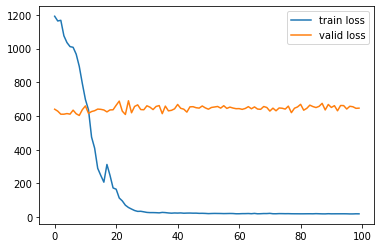

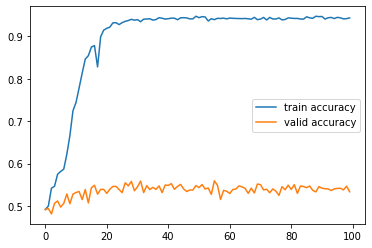

In [4]:
# Trainer.

num_actions_train = 8
num_actions_valid = 6
batch_size = 4
epochs = 100
lr = 1e-4

train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, data = train(
    model, 
    num_actions_train=num_actions_train, 
    num_actions_valid=num_actions_valid, 
    batch_size=batch_size, 
    epochs=epochs, 
    lr=lr
)

In [5]:
# Evaluation.

from eval_fi import eval_all_dataset
eval_all_dataset(model, path="/h/sagar/ece496-capstone/datasets/fi")

--------------------------------------------------
Action 1: in a bowl, add ground beef, salt, pepper, 1 egg, dijon mustard and bread crumbs
Best IoU possible = 0.8007769584655762
Random Candidate IoU = 0.625694990158081
Chosen Frame IoU: 0.5668710470199585
Best IoU possible = 0.5932643413543701
Random Candidate IoU = 0.43438395857810974
Chosen Frame IoU: 0.5455523729324341
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: mix the ingredients with hand
Best IoU possible = 0.5895182490348816
Random Candidate IoU = 0.3991318643093109
Chosen Frame IoU: 0.3524552881717682
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add vegetable oil in a pan
Best IoU possible = 0.7165105938911438
Random Candidate 

Best IoU possible = 0.8381999135017395
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.1040244799217684
Best IoU possible = 0.621212363243103
Random Candidate IoU = 0.3642124533653259
Chosen Frame IoU: 0.45981284976005554
--------------------------------------------------
Action 9: sprinkle cheese onto the pizza
Best IoU possible = 0.7559992074966431
Random Candidate IoU = 0.37805870175361633
Chosen Frame IoU: 0.5283874869346619
Best IoU possible = 0.6330073475837708
Random Candidate IoU = 0.3835006356239319
Chosen Frame IoU: 0.30489271879196167
Mean Upper Bound IoU: 0.7348538637161255, Mean Random IoU: 0.3244920074939728, Mean Model IoU: 0.34597325325012207
Top-1 acc@0.5:
Proposal Upper Bound: 0.9375, Random: 0.25, Model: 0.1875
--------------------------------------------------
Action 1: cut the cabbage into small pieces
Best IoU possible = 0.8861623406410217
Random Candidate IoU = 0.15250383129224146
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
-----------------

--------------------------------------------------
Action 1: Soak the ribs in water
Best IoU possible = 0.5058745682595212
Random Candidate IoU = 0.14596101641654968
Chosen Frame IoU: 0.2967672646045685
Best IoU possible = 0.8695003390312195
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 2: peel the apple and kiwi
Best IoU possible = 0.3941496014595032
Random Candidate IoU = 0.06246180832386017
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: cut the apple and kiwi
Best IoU possible = 0.20565617084503174
Random Candidate IoU = 0.09602852910757065
Chosen Frame IoU: 0.09034316949598674
This entity has no ground truth bounding box
--------------------------------------------------
Action 4: cut the onion and garlic
Best IoU possible = 0.03550495477541392
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.030935616602733574
Best IoU possible = 0.44695356488

--------------------------------------------------
Action 1: Add an egg yolk in mayo
Best IoU possible = 0.1718814903008678
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.1039382591843605
Best IoU possible = 0.6781991720199585
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.33506399393081665
--------------------------------------------------
Action 2: Shred some cheese in it
Best IoU possible = 0.626786470413208
Random Candidate IoU = 0.07606327533721924
Chosen Frame IoU: 0.25707079004079714
Best IoU possible = 0.6483603715896606
Random Candidate IoU = 0.057043980807065964
Chosen Frame IoU: 0.4067375361919403
--------------------------------------------------
Action 3: add salt and pepper to it
Best IoU possible = 0.605575419552428
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.2804690897464752
Best IoU possible = 0.6424552202224731
Random Candidate IoU = 0.014786533080041409
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
---------------------------------------------

Best IoU possible = 0.5790173411369324
Random Candidate IoU = 0.26328063011169434
Chosen Frame IoU: 0.0010062725050374866
Mean Upper Bound IoU: 0.7098140716552734, Mean Random IoU: 0.2913018763065338, Mean Model IoU: 0.41864171624183655
Top-1 acc@0.5:
Proposal Upper Bound: 0.95, Random: 0.1, Model: 0.35
--------------------------------------------------
Action 1: Cook pancetta in a pan with oil
Best IoU possible = 0.5042048316240199
Random Candidate IoU = 0.027109196409583092
Chosen Frame IoU: 0.4702042171011032
Best IoU possible = 0.769189715385437
Random Candidate IoU = 0.036373961716890335
Chosen Frame IoU: 0.48861512541770935
--------------------------------------------------
Action 2: Melt butter in a pan
Best IoU possible = 0.1002126033087652
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0026344163343310356
Best IoU possible = 0.5649166703224182
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.2073736935853958
--------------------------------------------------
Action 3: mix the fl

Best IoU possible = 0.5132518867765944
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 8: Add the sauce and udon noodles to the pan
Best IoU possible = 0.7526325583457947
Random Candidate IoU = 0.40296006202697754
Chosen Frame IoU: 0.5019660592079163
Best IoU possible = 0.462127685546875
Random Candidate IoU = 0.1677510142326355
Chosen Frame IoU: 0.3603138029575348
This entity has no ground truth bounding box
--------------------------------------------------
Action 9: stir
No entities detected for this action.
--------------------------------------------------
Action 10: place watercress on the dish
Best IoU possible = 0.41042817609035304
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 11: place the stir-fry on top of the watercress
Best IoU possible = 0.7481353878974915
Random Candidate IoU = 0.19797521829605103
Chosen Fram

--------------------------------------------------
Action 1: Add the meat to a bowl
Best IoU possible = 0.617917001247406
Random Candidate IoU = 0.5884137432255611
Chosen Frame IoU: 0.4843759834766388
Best IoU possible = 0.7723944783210754
Random Candidate IoU = 0.7246986031532288
Chosen Frame IoU: 0.47908952832221985
--------------------------------------------------
Action 2: Add garlic salt, sugar, sesame oil, and sauce to the meat
Best IoU possible = 0.7261868715286255
Random Candidate IoU = 0.12640167772769928
Chosen Frame IoU: 0.09476474672555923
Best IoU possible = 0.6844748258590698
Random Candidate IoU = 0.14724017679691315
Chosen Frame IoU: 0.1612728089094162
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add cabbage, green onion, and carrots to the bowl
Best IoU possible = 0.4498466998685286
Random Candidate IoU = 0.144005149602

Best IoU possible = 0.7070802450180054
Random Candidate IoU = 0.38970884680747986
Chosen Frame IoU: 0.4895331561565399
--------------------------------------------------
Action 8: add the onion rings into it
Best IoU possible = 0.7969423532485962
Random Candidate IoU = 0.40415775775909424
Chosen Frame IoU: 0.4847387373447418
Best IoU possible = 0.7849301695823669
Random Candidate IoU = 0.19979828596115112
Chosen Frame IoU: 0.4706958532333374
--------------------------------------------------
Action 9: shake it well to coat
Best IoU possible = 0.6910412907600403
Random Candidate IoU = 0.05298576503992081
Chosen Frame IoU: 0.39873677492141724
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: Dip the onion rings into the batter
Best IoU possible = 0.8711786270141602
Random Candidate IoU = 0.23306440843546436
Chosen Frame IoU: 0.052897680550813675
Best IoU possible = 0.8245587944984436
Random Candidate IoU = 0.4146212339401245
Chosen

Best IoU possible = 0.4333764051468516
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.21424990892410278
--------------------------------------------------
Action 12: Cook some pasta in the pan
Best IoU possible = 0.6306614083560957
Random Candidate IoU = 0.2318883091211319
Chosen Frame IoU: 0.5082798328410856
Best IoU possible = 0.6367907524108887
Random Candidate IoU = 0.029501378536224365
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 13: mix it with the sauce and pecorino cheese
Best IoU possible = 0.6135243773460388
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.27098897099494934
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.21799419722445557
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.591597318649292, Mean Random IoU: 0.16963233053684235, Mean Model IoU: 0.2883821427822113
Top-1 acc@0.5:
Proposal Upper Bound: 0.75, Random: 0.125, Model: 0.25
--------------------------------------------------
Action 

--------------------------------------------------
Action 1: cut through the core of the cabbage into half
Best IoU possible = 0.7646498084068298
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.2391720563173294
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: remove the tough core
Best IoU possible = 0.2688540816307068
Random Candidate IoU = 0.10127015604697501
Chosen Frame IoU: 0.06993007812706045
--------------------------------------------------
Action 3: dice the cabbage
Best IoU possible = 0.5835496187210083
Random Candidate IoU = 0.12102416902780533
Chosen Frame IoU: 0.55085289478302
--------------------------------------------------
Action 4: Put the cabbage into a pan
Best IoU possible = 0.1904536932706833
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.029704006388783455
Best IoU possible = 0.7283530235290527
Random Candidate IoU = 0.4979017674922943
Chosen Frame IoU: 0.48279619216918945
-----------------------------------

Best IoU possible = 0.7186981439590454
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.5374243855476379
--------------------------------------------------
Action 8: Fry the marinated chicken in a frying pan
Best IoU possible = 0.5074989674907074
Random Candidate IoU = 0.18545475602149963
Chosen Frame IoU: 0.38227977891944376
Best IoU possible = 0.6396270394325256
Random Candidate IoU = 0.38881537318229675
Chosen Frame IoU: 0.5649938583374023
--------------------------------------------------
Action 9: mix sesame oil, red chili in a pan
Best IoU possible = 0.1915578544139862
Random Candidate IoU = 0.02020462043583393
Chosen Frame IoU: 0.05231348996484614
Best IoU possible = 0.6757965087890625
Random Candidate IoU = 0.4394192099571228
Chosen Frame IoU: 0.3329809010028839
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: Cook until the red chili turns brown
No entities detected for this action.
---------------------------------------

Best IoU possible = 0.8428636193275452
Random Candidate IoU = 0.8088611364364624
Chosen Frame IoU: 0.45584502816200256
Best IoU possible = 0.5179982781410217
Random Candidate IoU = 0.37975162267684937
Chosen Frame IoU: 0.33043861389160156
--------------------------------------------------
Action 10: Add distilled vinegar to a pan of hot water
Best IoU possible = 0.8786023855209351
Random Candidate IoU = 0.2270300964805585
Chosen Frame IoU: 0.0
Best IoU possible = 0.5438989996910095
Random Candidate IoU = 0.2558498978614807
Chosen Frame IoU: 0.07561340928077698
--------------------------------------------------
Action 11: add eggs
Best IoU possible = 0.44652411341667175
Random Candidate IoU = 0.008350911550223827
Chosen Frame IoU: 0.2557521164417267
--------------------------------------------------
Action 12: split english muffins onto a tray
Best IoU possible = 0.8041749000549316
Random Candidate IoU = 0.32406991720199585
Chosen Frame IoU: 0.8041749000549316
Best IoU possible = 0.6631

Best IoU possible = 0.7337489724159241
Random Candidate IoU = 0.5714751482009888
Chosen Frame IoU: 0.3802674114704132
--------------------------------------------------
Action 8: stir
No entities detected for this action.
--------------------------------------------------
Action 9: mix flour and water together
Best IoU possible = 0.5302958871009986
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.03369451086494448
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: heat the paste in the microwave
Best IoU possible = 0.5879206758992289
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8753164410591125
Random Candidate IoU = 0.4865075647830963
Chosen Frame IoU: 0.20953814685344696
--------------------------------------------------
Action 11: place the filling on the corner of the wrapper
Best IoU possible = 0.5457116488835777
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.24618841707706451
Best IoU possible = 0.609

Best IoU possible = 0.5887230260069435
Random Candidate IoU = 0.297178715467453
Chosen Frame IoU: 0.2712501883506775
--------------------------------------------------
Action 10: Spread a layer of pizza sauce
Best IoU possible = 0.49806561342578604
Random Candidate IoU = 0.2504923641681671
Chosen Frame IoU: 0.2521170675754547
--------------------------------------------------
Action 11: add a layer of grated cheese
Best IoU possible = 0.6694362528398811
Random Candidate IoU = 0.4586627781391144
Chosen Frame IoU: 0.209836944937706
--------------------------------------------------
Action 12: place the sliced pepperoni
Best IoU possible = 0.504597657449338
Random Candidate IoU = 0.3878227045915503
Chosen Frame IoU: 0.17843195796012878
--------------------------------------------------
Action 13: put the fried bacon on top
Best IoU possible = 0.7825869917869568
Random Candidate IoU = 0.03719261131554181
Chosen Frame IoU: 0.0
Best IoU possible = 0.8435232639312744
Random Candidate IoU = 0.

Best IoU possible = 0.5980229377746582
Random Candidate IoU = 0.5163825750350952
Chosen Frame IoU: 0.47373902797698975
--------------------------------------------------
Action 8: cook the prosciutto in it
Best IoU possible = 0.7770838141441345
Random Candidate IoU = 0.3826281726360321
Chosen Frame IoU: 0.7770838141441345
Best IoU possible = 0.6303503513336182
Random Candidate IoU = 0.37160247564315796
Chosen Frame IoU: 0.034259214997291565
--------------------------------------------------
Action 9: Turn off the heat when the prosciutto is crispy
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: add the pasta to the boiling water
Best IoU possible = 0.910606861114502
Random Candidate IoU = 0.01972976140677929
Chosen Frame IoU: 0.3715575337409973
Best IoU possible = 0.6924198865890503
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.4273984432220459
--------------------------------------------------
Action 11: Add several cloves of

Best IoU possible = 0.11782408089816797
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.016247084438961643
Best IoU possible = 0.6219090223312378
Random Candidate IoU = 0.20373410375983123
Chosen Frame IoU: 0.30309629440307617
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 8: mix
No entities detected for this action.
--------------------------------------------------
Action 9: Add oil to a hot pan
Best IoU possible = 0.4818908257469039
Random Candidate IoU = 0.1284732073545456
Chosen Frame IoU: 0.3777375817298889
Best IoU possible = 0.49344107508659363
Random Candidate IoU = 0.2137928307056427
Chosen Frame IoU: 0.3311609625816345
--------------------------------------------------
Action 10: add the vegetables 
Best IoU possible = 0.86204594373703
Random Candidate IoU = 0.0372161790728569
Chosen Frame IoU: 0.41887548565864563
--------------------------------------------------
Action 11: m

Best IoU possible = 0.558673620223999
Random Candidate IoU = 0.3391171395778656
Chosen Frame IoU: 0.40500783920288086
--------------------------------------------------
Action 8: Put the balls in
Best IoU possible = 0.665919840335846
Random Candidate IoU = 0.2650783360004425
Chosen Frame IoU: 0.47036901116371155
--------------------------------------------------
Action 9: cook in batches
Best IoU possible = 0.6722113490104675
Random Candidate IoU = 0.36728087067604065
Chosen Frame IoU: 0.47148481011390686
--------------------------------------------------
Action 10: Add some cooking oil to a preheated pan
Best IoU possible = 0.8961031436920166
Random Candidate IoU = 0.6154971718788147
Chosen Frame IoU: 0.03485376760363579
Best IoU possible = 0.5106938481330872
Random Candidate IoU = 0.4915192127227783
Chosen Frame IoU: 0.014131160452961922
--------------------------------------------------
Action 11: Add onions, garlic
Best IoU possible = 0.8975192904472351
Random Candidate IoU = 0.457

--------------------------------------------------
Action 1: peel a onion
Best IoU possible = 0.6864221692085266
Random Candidate IoU = 0.42550885677337646
Chosen Frame IoU: 0.15270927548408508
--------------------------------------------------
Action 2: chop it into pieces
Best IoU possible = 0.7716975212097168
Random Candidate IoU = 0.5005788207054138
Chosen Frame IoU: 0.24950368702411652
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: heat the onion in a pot with olive oil in it
Best IoU possible = 0.7150817792313797
Random Candidate IoU = 0.4444286823272705
Chosen Frame IoU: 0.4526665210723877
Best IoU possible = 0.5248932838439941
Random Candidate IoU = 0.049487821757793427
Chosen Frame IoU: 0.4761808514595032
--------------------------------------------------
Action 4: Place some beef in the same pot
Best IoU possible = 0.7179511189460754
Random Candidate IoU = 0.21307969093322754
Chosen Frame IoU: 0.47775083780288696
Best

Best IoU possible = 0.7540024518966675
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.29185497760772705
Best IoU possible = 0.7634660601615906
Random Candidate IoU = 0.1732892394065857
Chosen Frame IoU: 0.29863241314888
--------------------------------------------------
Action 20: Cook the pierogies in salted boiling water until they float
Best IoU possible = 0.7422332167625427
Random Candidate IoU = 0.1572566032409668
Chosen Frame IoU: 0.45306819677352905
Best IoU possible = 0.8474924564361572
Random Candidate IoU = 0.611840009689331
Chosen Frame IoU: 0.442135214805603
--------------------------------------------------
Action 21: Spread melted butter on a plate
Best IoU possible = 0.20600686967372894
Random Candidate IoU = 0.009648396633565426
Chosen Frame IoU: 0.06146141384587078
Best IoU possible = 0.044203195720911026
Random Candidate IoU = 0.0156596340239048
Chosen Frame IoU: 0.00273747555911541
--------------------------------------------------
Action 22: transfer the cooked pier

Best IoU possible = 0.0972706526517868
Random Candidate IoU = 0.027045758441090584
Chosen Frame IoU: 0.04254471478190698
--------------------------------------------------
Action 10: Sprinkle some salt and pepper on both sides of the foie gras slice
Best IoU possible = 0.3749147653579712
Random Candidate IoU = 0.0789234262787688
Chosen Frame IoU: 0.0
Best IoU possible = 0.052892621606588364
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.01687064264305921
This entity has no ground truth bounding box
--------------------------------------------------
Action 11: place the seasoned foie gras in the pan
Best IoU possible = 0.38164618611335754
Random Candidate IoU = 0.1387348175048828
Chosen Frame IoU: 0.16831539571285248
Best IoU possible = 0.6917892694473267
Random Candidate IoU = 0.2033640444278717
Chosen Frame IoU: 0.5423192381858826
--------------------------------------------------
Action 12: cook until it is golden brown
No entities detected for this action.
--------------------------

Best IoU possible = 0.8673739433288574
Random Candidate IoU = 0.0184398852288723
Chosen Frame IoU: 0.13647179029726644
--------------------------------------------------
Action 5: add some olive oil, parsley and red pepper for spice
This entity has no ground truth bounding box
Best IoU possible = 0.7744495272636414
Random Candidate IoU = 0.2821952998638153
Chosen Frame IoU: 0.4235170781612396
This entity has no ground truth bounding box
--------------------------------------------------
Action 6: place the chunks on the skewers by personal favorite order
Best IoU possible = 0.11774572730064392
Random Candidate IoU = 0.06302956491708755
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 7: heat the grill to medium to high heat
Best IoU possible = 0.4842504560947418
Random Candidate IoU = 0.46338707208633423
Chosen Frame IoU: 0.37844276428222656
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.6

--------------------------------------------------
Action 1: Put flour, salt, paparika to a bowl
Best IoU possible = 0.6384642124176025
Random Candidate IoU = 0.4349724352359772
Chosen Frame IoU: 0.48201099038124084
Best IoU possible = 0.7336183786392212
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.3134220540523529
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: Add some water
Best IoU possible = 0.8549069166183472
Random Candidate IoU = 0.27837756276130676
Chosen Frame IoU: 0.30056434869766235
--------------------------------------------------
Action 3: keep stirring
No entities detected for this action.
--------------------------------------------------
Action 4: Chop some squid into rings
Best IoU possible = 0.5646544098854065
Random Candidate IoU = 0.10272140055894852
Chosen Frame IoU: 0.02318074367940426
This entity has no ground truth bounding box
-----------------------------

Best IoU possible = 0.781658411026001
Random Candidate IoU = 0.0845152959227562
Chosen Frame IoU: 0.693206250667572
Best IoU possible = 0.8017827272415161
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.22205635905265808
Mean Upper Bound IoU: 0.4534668028354645, Mean Random IoU: 0.03128883242607117, Mean Model IoU: 0.15167348086833954
Top-1 acc@0.5:
Proposal Upper Bound: 0.5833333333333334, Random: 0.0, Model: 0.08333333333333333
--------------------------------------------------
EVALUATION SUMMARY
Number of videos: 54
Mean IoU:
	Proposal Upper Bound: 0.5985851287841797
	Random: 0.18819482624530792
	Model: 0.2766225337982178
Top-1 accuracy@0.5:
	Proposal Upper Bound: 74.9%
	Random: 8.3%
	Model: 16.1%
--------------------------------------------------


In [ ]:
# Visualizer.

from visualizer import inference

YCII = "/h/sagar/ece496-capstone/datasets/ycii"
FI = "/h/sagar/ece496-capstone/datasets/fi"

VG, RR = inference(model, 27, 0, FI)

In [ ]:
# Saving and loading weights.

SAVE = False
LOAD = True

if SAVE:
    torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/t1")
    
if LOAD:
    model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/t1"))

In [ ]:
# Reload modules.

import importlib
import visualizer
import eval_fi
import model as mdl
import loss

importlib.reload(visualizer)
importlib.reload(eval_fi)
importlib.reload(mdl)
importlib.reload(loss)